# Data Programming with Python - STAT40800 
## Project: COVID-19 Data Analysis and Zonal Division
## Ninad Thaker - 20202926 

# Introduction

## Project Background

$\color{gray}{\text{A virus originated from PRC's Wuhan has taken lives of 1.17M people.}}$
$\color{gray}{\text{With total of 44.5M cases registered worldwide till date.}}$
$\color{gray}{\text{During this unfortunate time, maintaining physical distancing and wearing mask has become necessity. However, the cases are still increasing}}$
$\color{gray}{\text{every single day. Hence, to avoid exposure to the virus and to keep people safe, worldwide more than 100 countries imposed full or}}$
$\color{gray}{\text{partial lockdowns with different levels over the course of the year. The levels of the lockdown are changed based on the number}}$
$\color{gray}{\text{of cases and deaths registered.}}$


## Problem Statement

$\color{gray}{\text{This Project will look at the data for the Republic of Ireland inorder to analyze the cases per county graphically and to potentially help for making}}$
$\color{gray}{\text{decision on what level of movement restriction must be imposed on a county and on the nation if and when needed to avoid the spread of the}}$
$\color{gray}{\text{Novel Coronavirus.}}$


## Objectives

1) We will first perform ETL - Extract Transform Load on the data to identify and select only the data which is useful for our project.

2) We will then plot the Time Series plots for a few counties and visualize their situation for 8 months.

3) Then we are interested to in the Correlation analysis of the counties i.e. we want to find if there is a chance of getting infected when travelling from one to another county.

4) We want to control the future cases so we will create a method to find the current cases and based on that we will tag the counties for division i.e. Zonal Division is Red being highest case count, Orange with medium amount of cases which could skyrocket or decline in future and Green as low case count as of now.

5) Once we find and decide the zones for each county, we will plot them on the MAP as this would allow us to visualize how well or bad each county is doing and through that we may impose the levels of lockdowns to allow only authorized movement to allow general public movement with limited access/ gathering etc.


### NOTE:

The dataset used in this project is taken from https://data.gov.ie/dataset/covid19countystatisticshpscirelandopendata1, and is updated periodically.
There could be some missing/inaccurate data in this dataset but for the purpose of this project, we will assume that this is accurate and based on that we will perform our analytical tasks.


The MAP related files can be found on https://gadm.org/download_country_v3.html by selecting "Ireland" and downloading the Shapefile.


## Importing Packages

#### The following is a complete list of packages used in this project:  

1) collections  
2) numpy  
3) pandas  
4) seaborn  
5) matplotlib  
6) geoplot  
7) geopandas  
8) shapefile  

#### The packages can be installed using one of the following methods...

1) WinPython:
`pip install numpy pandas seaborn matplotlib geopandas geoplot shapefile`

2) Anaconda:
`conda install numpy pandas seaborn matplotlib geopandas geoplot shapefile`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
from pandas import DataFrame, Series
import geoplot as gpt
import geopandas as gpd
import shapefile as shp

## ETL - Extract Transform Load

Assuming that the files are present in the given folder we will move forward. If the there is missing file(s) or the format of the covid file is wrong, the execution will stop. We have used `SystemExit` to stop Jupyter from running further cells but we also don't want to kill the kernel which otherwise would happen if we use `the exit()`

In [2]:
covid_file = 'D:/Ireland/UCD/Autumn/DPP(ONL)_STAT40800_CRN61452/Project/Data/Covid19CountyStatisticsHPSCIreland.csv'

ireland_map_counties_shp = 'D:/Ireland/UCD/Autumn/DPP(ONL)_STAT40800_CRN61452/Project/Data/Map/Shp/gadm36_IRL_1.shp'


if (covid_file[-4:]==".csv") and (ireland_map_counties_shp[-4:]==".shp"):
    cases_by_county_ireland = pd.read_csv(covid_file)
    map_df = gpd.read_file(ireland_map_counties_shp)
    
    if len(list(set(cases_by_county_ireland.columns) - set(['OBJECTID', 'ORIGID', 'CountyName', 'PopulationCensus16', 
                                                            'TimeStamp','IGEasting', 'IGNorthing', 'Lat', 'Long', 'UGI', 
                                                            'ConfirmedCovidCases', 'PopulationProportionCovidCases', 
                                                            'ConfirmedCovidDeaths', 'ConfirmedCovidRecovered', 
                                                            'Shape__Length', 'Shape__Area']))) != 0:
        raise SystemExit("Incorrect COVID-19 Data file columns")
    
else:
    raise SystemExit("Incorrect File(s) extension/ Missing File(s)")
    

Now, that we have the files loaded into `cases_by_county_ireland` for Covid data and `map_df` for Map files as dataframes, we can start the data cleaning process.

We will first drop the columns which are of no use for the purpose of the analysis. The first confirmed case of covid 19 according to the `csv` file was registered on **March 21, 2020**. The data is then available up to **October 29, 2020**. At the time of performing analysis, the data for the motnth of November isn't available so we will just keep the track of the data from March to October which is 8 months in total. This can be vary easily changed for any number of months/years with the availability of the dataset. But for now we are keeping it static for the 8 months only.

The Shapfile data contains the map border for country as well as each administrative counties of Ireland. There are some columns which are specifically more useful to hilight or pin point a region or entire country when plotted. We use GeoPandas to manipulate those columns in such a way that what we want to achieve can be done with the combination of the covid data and the shape data.

The Confirmed Cases are cumulative i.e. they are not per day registration of the cases, they are total cases registered in a particular county. We will normalize this and convert them to per day basis later when needed. Because it is easy to convert for one county for given duration of 8 months but we have 26 counties, which will make the process unnecessarily complex.

In [3]:
# Finding population by eacch county
population_by_county = cases_by_county_ireland.head(26)[['CountyName','PopulationCensus16']]

# Rename the column headers
population_by_county = population_by_county.rename(columns={'CountyName':'County','PopulationCensus16':'Population'})

# Find Latitude and Longitude of each county
geo_county = cases_by_county_ireland.head(26)[['CountyName','Lat','Long',
                                               'Shape__Area','Shape__Length']].rename(columns={
    'CountyName':'County','Shape__Area':'Area','Shape__Length':'Length'})


# Selecting data from when First Covid case was registered & Dropping columns that are not required 
cases_by_county_ireland = cases_by_county_ireland[546:].reset_index().drop(['index','OBJECTID','UGI','IGEasting','IGNorthing',
                                                                            'Lat','Long','Shape__Area','Shape__Length',
                                                                            'ConfirmedCovidRecovered','ConfirmedCovidDeaths']
                                                                             ,axis='columns')
# Total number of cases in Ireland
country_total_cases = sum(cases_by_county_ireland.ConfirmedCovidCases)

# Convert TimeStamp to Date only
Date = pd.to_datetime(cases_by_county_ireland.TimeStamp).dt.date.unique()

# Rename column headers
cases_by_county_ireland = cases_by_county_ireland.rename(columns={'ORIGID':'CountyID','PopulationCensus16':'Population'})


# Creating Geo Dataframe for plotting counties on MAP
counties_df = gpd.GeoDataFrame(geo_county,
                               geometry = gpd.points_from_xy(geo_county.Long, geo_county.Lat))


# List of a few counties in which we are interested
county_list = ['Cork','Dublin','Mayo','Wicklow','Galway','Clare']

# Looking at data for the first day for all of the counties
cases_by_county_ireland.head(26)

,CountyID,CountyName,Population,TimeStamp,ConfirmedCovidCases,PopulationProportionCovidCases
0,1,Carlow,56932,3/21/2020 0:00,3,5.269444
1,2,Cavan,76176,3/21/2020 0:00,3,3.938248
2,3,Clare,118817,3/21/2020 0:00,9,7.574674
3,4,Cork,542868,3/21/2020 0:00,104,19.157512
4,5,Donegal,159192,3/21/2020 0:00,8,5.025378
5,6,Dublin,1347359,3/21/2020 0:00,471,34.957276
6,7,Galway,258058,3/21/2020 0:00,33,12.787823
7,8,Kerry,147707,3/21/2020 0:00,12,8.124192
8,9,Kildare,222504,3/21/2020 0:00,23,10.336893
9,10,Kilkenny,99232,3/21/2020 0:00,15,15.116092


It is very clear that the cases are registered in counties where population is high compared to other counties and majority of counties had cases under 50 which is again cumulative count.


## Time Series Analysis

We know that the spread of virus isn't same everywhere. Some counties have faced worse situation while some had minimul impact on them. This is easily represented by a Time Series Plot. It'll allow us to see the trend and decline in cases along with the period where the cases seemd to be in controlled.

Let's first plot the Capital of Ireland - county **Dublin**, and viaualize the case registration. To do that we will first need to find the county Dublin from all the counties' data. Once we have that, as we discussed earlier that the cases are cumulative, we now will normalize them, and because March 21,2020 was first day in this dataset, we can expect a little jitter in starting considering the data before that is not available. Finally, we plot the cases vs their dates using matplotlib i.e. we plot the Time Series data for the the county Dublin which includes data from March to October.

(array([737516., 737546., 737577., 737607., 737638., 737669., 737699.,
        737730.]),
 <a list of 8 Text major ticklabel objects>)

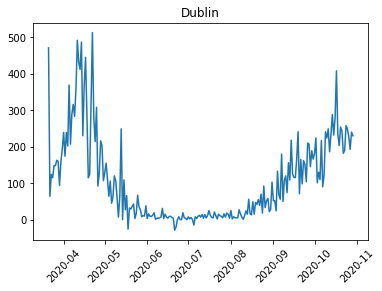

In [4]:
# Dublin county data for timeseries
dublin = cases_by_county_ireland[cases_by_county_ireland.CountyName=="Dublin"]
dublin = dublin.reset_index()
# Plot Timeseries of Dublin county from March 21st to October 29th
dublin_cases_per_day = [dublin.ConfirmedCovidCases[0]]
for i in range(1,len(dublin.ConfirmedCovidCases)):
    dublin_cases_per_day.append(dublin.ConfirmedCovidCases[i]-dublin.ConfirmedCovidCases[i-1])
plt.plot(Date,dublin_cases_per_day)
plt.title("Dublin")
plt.xticks(rotation=45)

Like we expected, we can see that jitter but that's totally okay. The Series plot shows that the cases registered in the month of **April - May** were highest among entire 8 month time span. There is a relax period from Mid May to Mid August were cases can be found about under 100.

Well, this is just one county, what if we want to explore more than one?

Let's make the code more *__generalized__* where we can give a list which is made of all the counties we want to look, and derive our analysis

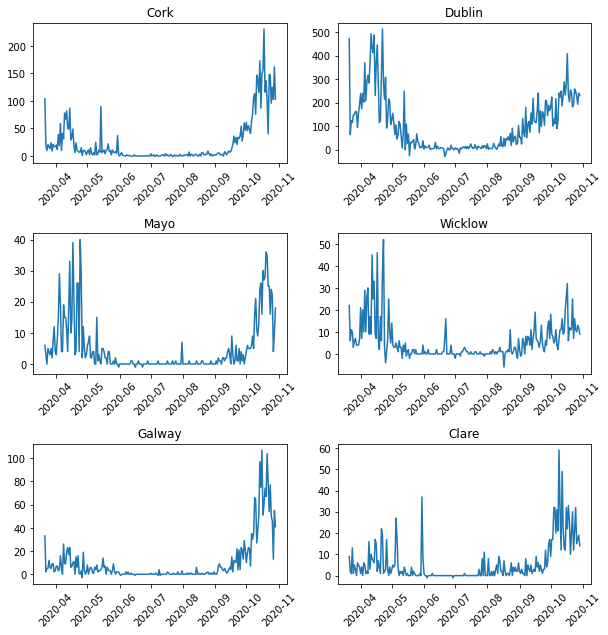

In [5]:
# Timeseries for multiple counties
multiple_counties_timeseries = cases_by_county_ireland[cases_by_county_ireland.CountyName.isin(county_list)]

# Find number of counties
length = len(county_list)

# Prepare the matplotlib subplot window based on the number of counties
if length%2 == 0:
    fig, axs = plt.subplots(int(length/2), 2,figsize=(10,10))
    # If even number of counties, no need to add extra row
    add = 0
else:
    fig, axs = plt.subplots(int(length/2)+1, 2,figsize=(10,10))
    # If odd number of counties, add 1 extra row
    add = 1

# Create bottom and height space between each subplot
plt.subplots_adjust(bottom=0.1,hspace=0.5)

# Iterate over the length of counties and skip to end (The i loop run for once only)
for i in range(0,length,length):
    # Iterate over the rows for subplot and add extra row if the length is not even
    for j in range(int(length/2)+add):
        # Iterate over the columns for subplot
        for k in range(2):
            # Plot date and cases on j,k subplot
            
            county = multiple_counties_timeseries[multiple_counties_timeseries.CountyName==county_list[i]].reset_index()
            county_per_day_cases = [county.ConfirmedCovidCases[0]]
            for x in range(1,len(county.ConfirmedCovidCases)):
                county_per_day_cases.append(county.ConfirmedCovidCases[x]-county.ConfirmedCovidCases[x-1])
            
            axs[j,k].plot(Date,county_per_day_cases)
            # Set title of each subplot as the name of the county
            axs[j,k].set_title(str(county_list[i]))
            # Rotate x-axis ticks for each subplot by 45 degree
            axs[j,k].tick_params('x',labelrotation=45)
            # Increment county list by 1
            i+=1
            # If the county list is odd, check if the current value of j is equal to last iteration of j loop or not
            if j==(int(length-1)/2):
                # If condition above is true, then delete last subplot to adjust odd number of subplots
                fig.delaxes(axs[j,k+1])
                # Once done, break all loops to avoid list index out of bounds error
                break

Immediately it is visible that out of the 6 counties, except Dublin all of the counties for the most part of the this 8 month period had less than 100 cases which is can be expected as one they are counties with less population and they might not be a hub for major company/ headquarters which could trigger the high transportation rate.


## Correlation Analysis

We have information of cases on the individual counties and we know how it is reflecting across the time span. Now, we are interested in answering the question that is there any relation between 2 counties? i.e. if there is increase in cases in one county, what impact that has on other county - do the other county faces increase too or it is opposite of that and they see decline in cases or there's no effect?! 

Those questions are important because let's say we wanted to travel to another county but would we be risking ourselves by travelling to that county? And if the answer to that question is **YES** then how much chance there is of being infected? The answers to our previous question could help derive the answer to this question.

We don't need normalized cases here as we are interested in the total case count relation. To find correlation, we will first use our data from Dublin county and we will take a new county say Wicklow and compare the county Dublin against Wicklow. As before we will first quickly normalize the cases for Wicklow county. Then using the numpy correlation of coefficient we will scatter plot the cases.

The correlation is measured in the range **[-1, 1]** where  

1) **-1** means _**Negative**_ correlation which suggests that **with increase** in a unit case in one county, the other sees **decrease** or vice versa.  
2) **0** means _**No**_ correlation which suggests there is **no impact** of increase in cases of one county on other or vice versa.  
3) **1** means _**Positive**_ correlation which suggeests that **with increase** in a unit case in one county, the other sees **increment** or vice versa.  

The correlation between cases of county Dublin and Wicklow is 0.7685269055740646 and this means they are highly correlated.
Hence, if the number of cases increase for County Dublin, it will also increase for County Wicklow.


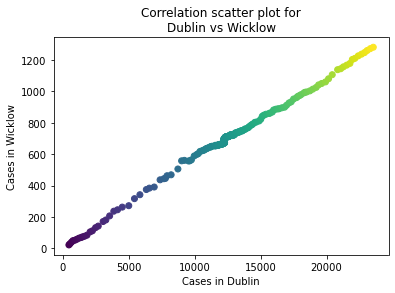

In [6]:
# Correlation between counties
wicklow = cases_by_county_ireland[cases_by_county_ireland.CountyName=="Wicklow"]
wicklow = wicklow.reset_index()

wicklow_cases_per_day = [wicklow.ConfirmedCovidCases[0]]
for i in range(1,len(wicklow.ConfirmedCovidCases)):
    wicklow_cases_per_day.append(wicklow.ConfirmedCovidCases[i]-wicklow.ConfirmedCovidCases[i-1])

# Finding coef of corr for Dublin vs Wicklow
print("The correlation between cases of county Dublin and Wicklow is",
      (np.corrcoef(dublin_cases_per_day,wicklow_cases_per_day))[0,1],
     "and this means they are highly correlated.\n"+
     "Hence, if the number of cases increase for County Dublin, it will also increase for County Wicklow.")

# Plot scatter of Dublin vs wicklow with c(color)
plt.scatter(dublin.ConfirmedCovidCases,wicklow.ConfirmedCovidCases,c=dublin.ConfirmedCovidCases)
plt.xlabel('Cases in Dublin')
plt.ylabel('Cases in Wicklow')
plt.title("Correlation scatter plot for\nDublin vs Wicklow")
plt.show()

The correlation is ~ 0.77 and they are highly correlated but what is more _interesting_ here is that with almost 5000 case increment in the cumulative case count for Dublin, the county Wicklow shows increment of 200 cases! That about 4% of the cases the Dublin county.

This allows us to understand that even if there is high correlation, and if we were to travel from Dublin to Wicklow, chances of getting infected is pretty low right? But then it is extremly high if we travel from Wicklow to Dublin!! So we'd rather not travel and impose restriction on travel to and from Dublin in order to stop the spread and control the case count.

Let's visualize the correlation between multiple counties. We already have our list of counties and using the numpy we can find the correlation matrix between all the counties we want. Then to visualize, we'll convert that matrix to a pandas dataframe object which will allow us to find the correlation between each possible counties. Finally, we plot the correlations using seaborn heatmap. The colors of heatmap vary from **Yellow** to **Green** to **Blue** gradually with increase in the correlation. Note that correlation of the county with itslef would be always **1**.

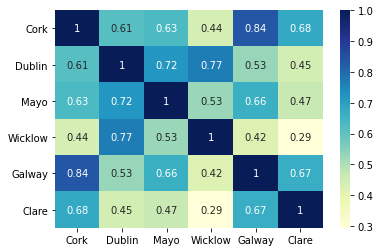

In [7]:
# Correlation Matrix of multiple counties
multiple_counties = cases_by_county_ireland[cases_by_county_ireland.CountyName.isin(county_list)]

# Create empty list to add per county confirmed cases
correlation_counties = []

# For each county in county_list, append confirmed covid cases by days to the list created above
for i in range(length):
    # First reset index for county i
    county = multiple_counties[multiple_counties.CountyName==county_list[i]].reset_index()
    # Day 1 must be present as there was no case registered before that
    county_per_day_cases = [county.ConfirmedCovidCases[0]]
    # Find cases per day for county i
    for j in range(1,len(county.ConfirmedCovidCases)):
        county_per_day_cases.append(county.ConfirmedCovidCases[j]-county.ConfirmedCovidCases[j-1])
    # Add cases per day for county i to correlation list
    correlation_counties.append(county_per_day_cases)

# Convert basic list to numpy 2D array and take transpose to produce columns
correlation_counties = np.array(correlation_counties).T

# Convert numpy 2D array to pandas DataFrame with county names as column headings
correlation_counties = pd.DataFrame(data=correlation_counties,columns=county_list)

# Find correlation matrix of all counties using pandas DataFrame.corr() method 
correlationMatrix = correlation_counties.corr()

# Plot seaborn heatmap of correlation matrix
sns.heatmap(correlationMatrix, annot=True,cmap="YlGnBu",)
plt.yticks(rotation=0)
plt.show()

From the correlation matrix we can say that correlation is mostly > 0.5 which is too much considering that there are 26 counties, it'd mean that the cases would skyrocket if we don't control them and that's true if we look back at the Time Series plot, we imposed the lockdown and result was that relax period. But as soon as we lifted that we again saw increment.


## MAPs

Let's take a detour. We know that the data we have is a little complex to visualize considering 26 counties x daily cases for 8 months. But we can easily represent that by a MAP. Plotting the geographical data on map would allow us to eyeball all the counties we want for entire time span.

Now, before we move towards how to calculate that data and plot it geographically we need to understand how geographical plotting works so that when we do the calculation, it would be easy for us to reflect that on the MAP.

Remember that we loaded 2 files, one was the covid data file and the other was the Shapedata file. Well it's about time we use it in conjunction with matplotlib. Let's start from basic by plotting the MAP of Ireland and pin pointing respective counties with their names.

Text(0.5, 1.0, 'Republic of Ireland')

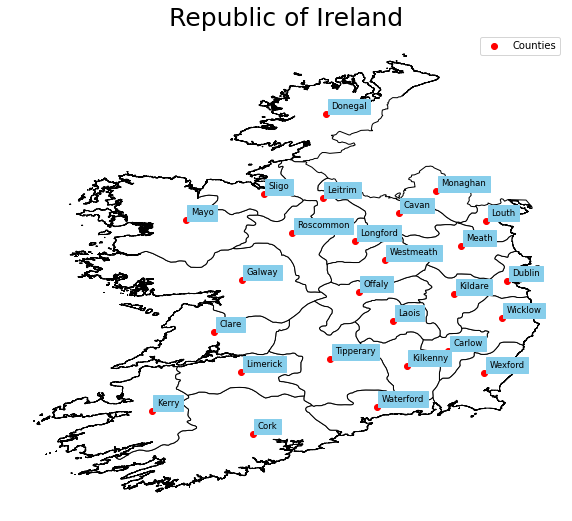

In [8]:
# Setting parameters of image size, color and edge for MAP of Ireland
fig, ax = plt.subplots(1, 1, figsize=(10,20))
ax = map_df.plot(ax=ax,color='white', edgecolor='black')

# Plotting MAP with counties maeked as Red dot
counties_df.plot(ax=ax,color='red')

# Adding MAP title, County labels to the Red dot and legend
for x, y, label in zip(counties_df.geometry.x, counties_df.geometry.y, counties_df.County):
    ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points",backgroundcolor="skyblue",size=8.5)
    
# No axis, set legend and title
ax.axis('off')
ax.legend(['Counties'])
ax.set_title('Republic of Ireland', fontdict={'fontsize': 25, 'fontweight' : 3})

That was easy! Each label represents the respective county and we now have a complete MAP.


Since our objective is to reflect counties we want on the map with their respective zone color, let's first plot a county maybe Dublin with some random color on the MAP with pin point and it's label.

Text(0.5, 1.0, 'Republic of Ireland')

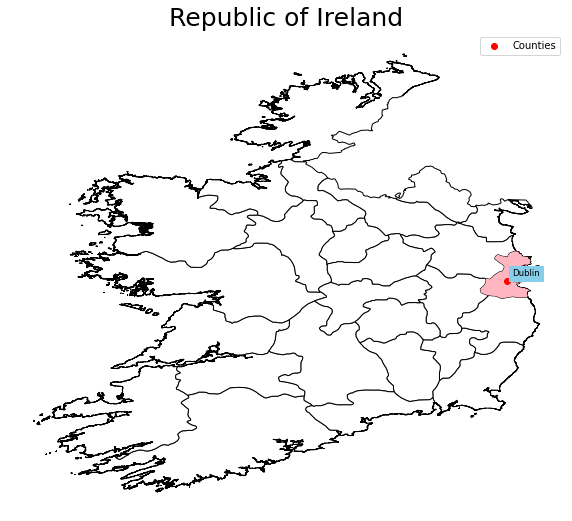

In [9]:
# Plot individual county on MAP with color
dublin_map_df = map_df[map_df.NAME_1=="Dublin"]

# Setting parameters of image size, color and edge for MAP of Ireland
fig, ax = plt.subplots(1, 1, figsize=(10,20),sharex=True)
ax = map_df.plot(ax=ax,color='white', edgecolor='black')

# Setting county and color 
ax = dublin_map_df.plot(ax=ax,color='lightpink')
counties_df[counties_df.County=="Dublin"].plot(ax=ax,color='red')

# Adding MAP title, County labels to the Red dot and legend
for x, y, label in zip(counties_df.geometry.x, counties_df.geometry.y, counties_df.County):
    if label == "Dublin":
        ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points",backgroundcolor="skyblue",size=8.5)

# No axis, set legend and title
ax.axis('off')
ax.legend(['Counties'])
ax.set_title('Republic of Ireland', fontdict={'fontsize': 25, 'fontweight' : 3})

Looks good! We have control over indivisual county but how about plotting our entire county list? Let's plot them with different colors say rainbow.

Text(0.5, 1.0, 'Republic of Ireland')

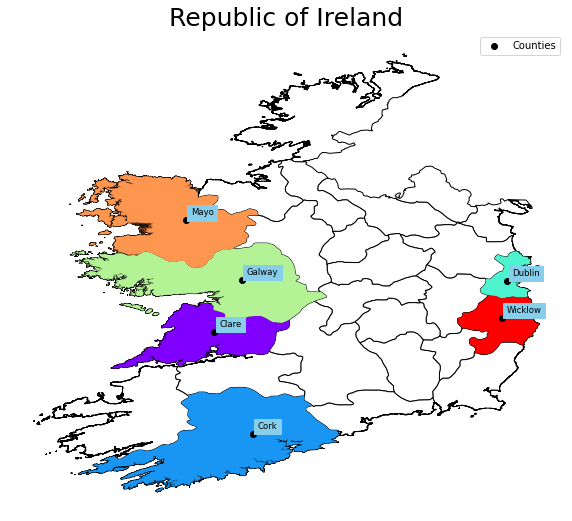

In [10]:
# Plot multiple counties on MAP with color

multiple_counties_map_df = map_df[map_df.NAME_1.isin(county_list)]

fig, ax = plt.subplots(1, 1, figsize=(10,20),sharex=True)
ax = map_df.plot(ax=ax,color='white', edgecolor='black')
ax = multiple_counties_map_df.plot(ax=ax,cmap='rainbow')
counties_df[counties_df.County.isin(county_list)].plot(ax=ax,color='black')

# Adding MAP title, County labels to the dot and legend
for x, y, label in zip(counties_df.geometry.x, counties_df.geometry.y, counties_df.County):
    if label in(county_list):
        ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points",backgroundcolor="skyblue",size=8.5)
        
ax.axis('off')
ax.legend(['Counties'])
ax.set_title('Republic of Ireland', fontdict={'fontsize': 25, 'fontweight' : 3})

Great! we got all we wanted, we plotted the MAP of Ireland with individual all counties labeled, we plotted a single county to show we can control individual county on map, and we plotted counties from our list.

## COVID - 19 Zonal Division

Let's get back to objective of finding zones for each county through which we'd able to impose the lockdown.

The county Dublin has shown the most cases so first we are going to find the zone in which the county should be considered. To keep it simple we will just look at the initial case registration data i.e. March 21,2020 to April 20,2020 - a Month.  


1) Let's assume that if there are **<= 1000** cases in last 30 days, then the county is in green zone  
2) If there are **> 1000& <= 5000** cases in last 30 days, then the county is in orange zone  
3) If there are **> 5000** cases in last 30 days, then the county is in red zone  


Now we know keeping counties under lockdown will help in controlling the cases but if there are more counties in general with more cases, it would be wise to put lockdown on entire country to avoid any more progression of the cases.  


1) If total **Red zone + total Orange zone > total Green zone**, then country is red zone else otherwise  
2) If total **Red zone + total Orange zone <= total Green zone**, then country is in Green zone else otherwise  

Text(0.5, 1.0, 'Republic of Ireland')

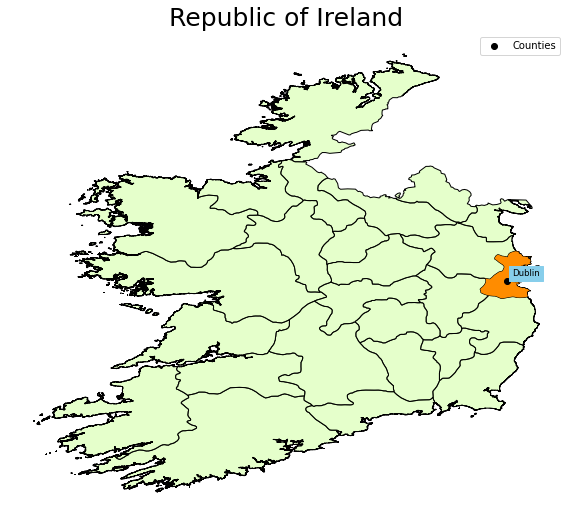

In [11]:
def set_county_color(total_cases_month):
    if (total_cases_month<=1000):
        color = 'green'
    elif (total_cases_month>1000 & total_cases_month<=5000):
        color = 'darkorange'
    else:
        color = 'red'
    return color

def set_country_zone(red_county,orange_county,green_county):
    if red_county + orange_county > green_county:
        #country_zone = 'peachpuff'
        country_zone = (0.8,1,0.6,0.5)
    elif red_county + orange_county <= green_county:
        #country_zone = 'lightyellow'
        country_zone = (1,0.9,0.2,0.5)
    return country_zone

# Automate pending of every 30 days map for one county
total_days = len(dublin.ConfirmedCovidCases)
total_month = int(total_days/30)

# Total case in the month - taking 31 days[0:31 => idx 0 to 30 where idx 30 is 31st day which is next month's day 1]
total_cases_month = dublin.ConfirmedCovidCases[0:31].iloc[-1]-dublin.ConfirmedCovidCases[0:31].iloc[0]

county_color = set_county_color(total_cases_month)
country_zone = set_country_zone(1,0,0)

# MAP by cases
fig, ax = plt.subplots(1, 1, figsize=(10,10),sharex=True)
ax = map_df.plot(ax=ax,color=country_zone, edgecolor='black')

# Setting county and color 
ax = dublin_map_df.plot(ax=ax,color=county_color)
counties_df[counties_df.County=="Dublin"].plot(ax=ax,color='black')

# Adding MAP title, County labels to the Red dot and legend
for x, y, label in zip(counties_df.geometry.x, counties_df.geometry.y, counties_df.County):
    if label == "Dublin":
        ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points",backgroundcolor="skyblue",size=8.5)

# No axis, set legend and title
ax.axis('off')
ax.legend(['Counties'])
ax.set_title('Republic of Ireland', fontdict={'fontsize': 25, 'fontweight' : 3})

During the **March - April** county Dublin was in the the orange zone! That makes sence considering the number of cases were high in Dublin compared to other counties.

But we know that the cases for other counties were in the range of 100s for almost entire time span so we'd need to modify the limits we declared earlier to accomodate all the counties.  

1) Let's assume that if there are **<= 100** cases in last 30 days, then the county is in green zone  
2) If there are **> 100 & <= 200** cases in last 30 days, then the county is in orange zone  
3) If there are **> 200** cases in last 30 days, then the county is in red zone  

We can still keep the country wide division the same.  

1) If total **Red zone + total Orange zone > total Green zone**, then country is red zone else otherwise  
2) If total **Red zone + total Orange zone <= total Green zone**, then country is in Green zone else otherwise  


## We'll divide our code in 3 parts...  

## 1) Functions to find and set zonal profiles for each county and country

In [12]:
###########################################################
#                    FUNCTIONS (Start)                    #  
###########################################################
def set_county_color(total_cases_month):
    if (total_cases_month<=100):
        color = 'green'
    elif (total_cases_month>100 & total_cases_month<=200):
        color = 'darkorange'
    else:
        color = 'red'
    return color

def set_country_zone(zone_list):
    zones = Counter(zone_list)
    if zones['red'] + zones['darkorange'] > zones['green']:
        country_zone = 'peachpuff'
        #country_zone = (0.8,1,0.6,0.5)
    elif zones['red'] + zones['darkorange'] <= zones['green']:
        country_zone = 'lightyellow'
        #country_zone = (1,0.9,0.2,0.5)
    return country_zone

def set_county_profile(county_case_registration):
    county_profile = []
    for i in range(length):
        temp = []
        # Since we wawnt to see the total cases per month to set color and level, we will look at 1st index of each sublist
        for j in range(len(county_case_registration[i][1])):
            # Now we are in the sublist with total monthly cases of acounty so we will index though each month
            temp.append(set_county_color(county_case_registration[i][1][j]))
        county_profile.append(temp)    
    return county_profile

def set_country_profile(county_profile):
    country_profile = []
    # Since we have 7+1 = 8 months, we need to fix a month and then from each county find the color total for country
    for j in range(total_months+1):
        temp = []
        for i in range(length):
            # Each county's i month color value
            temp.append(county_profile[i][j])
        # Now we have color for ith month from each county, let's call set_country_zone
        country_profile.append(set_country_zone(temp))     
    return country_profile
###########################################################
#                    FUNCTIONS (End)                      #  
###########################################################

## 2) Zonal Division for each county from list with normalized cases for 8 month time span

In [13]:
###########################################################
#                   Calculation (Start)                   #  
###########################################################
county_case_registration = []

for i in range(length):
    
    # First reset index for county i
    county = multiple_counties[multiple_counties.CountyName==county_list[i]].reset_index()
    
    # Day 1 must be present as there was no case registered before that
    county_cases_per_day = [county.ConfirmedCovidCases[0]]
    
    # Find cases per day for county i
    for j in range(1,len(county.ConfirmedCovidCases)):
        y = county.ConfirmedCovidCases[j]-county.ConfirmedCovidCases[j-1]
        if y<0:
            y=0
        county_cases_per_day.append(y)
    # Total Days nd Months
    total_days = len(county_cases_per_day)
    total_months = int(total_days/30)
    
    county_cases_per_month = []
    county_total_cases_per_month = []
    j=0
    k=30
    for i in range(total_months):
        # need 0:30 first month, 30-60 second month upto 8 months
        county_cases_per_month.append(county_cases_per_day[j:k])
        county_total_cases_per_month.append(sum(county_cases_per_month[i]))
        # increment j and k by 30 after each month only if this iteration is not last
        if i!=total_months-1:
            j+=30
            k+=30
    # Per month cases in county i
    county_cases_per_month.append(county_cases_per_day[k:])
    # Per month total cases in county i 
    county_total_cases_per_month.append(sum(county_cases_per_month[total_months]))
    
    # Add both of above to a list for future access for map and timeseries
    county_case_registration.append([county_cases_per_month,county_total_cases_per_month])

#### Now that we have cases per month, time series and MAP is possible per county/month 
#### total timeseries = 7 months + 1 = 8 x 5 counties = 40 and total map = 8 
county_profile = set_county_profile(county_case_registration)
country_profile = set_country_profile(county_profile)
###########################################################
#                   Calculation (End)                     #  
###########################################################

## 3) Combine the Division with respective counties and Plot them on MAP


### Note: It will take a few seconds to run the code

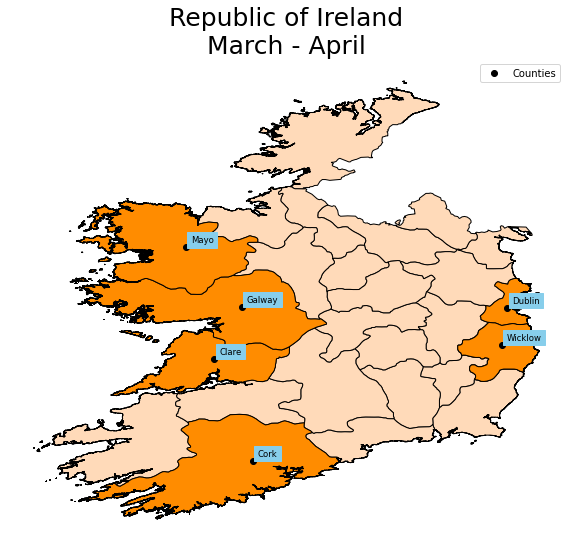

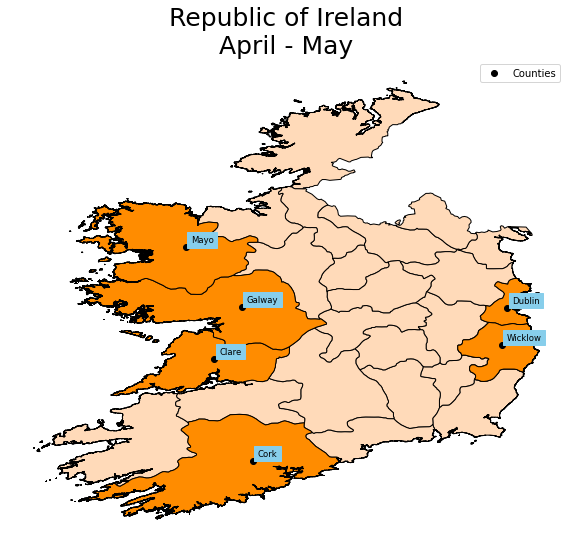

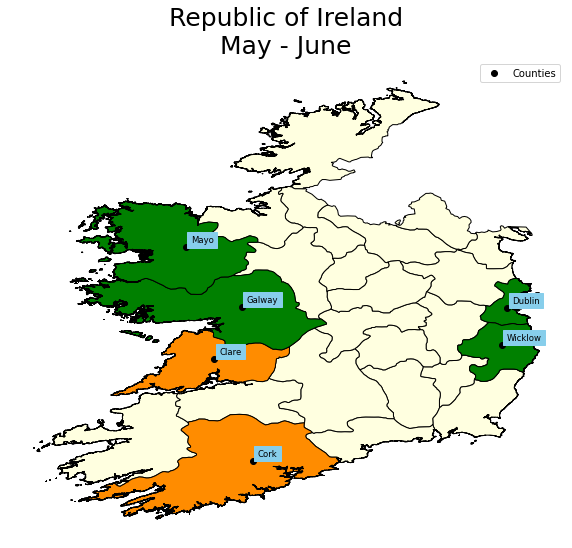

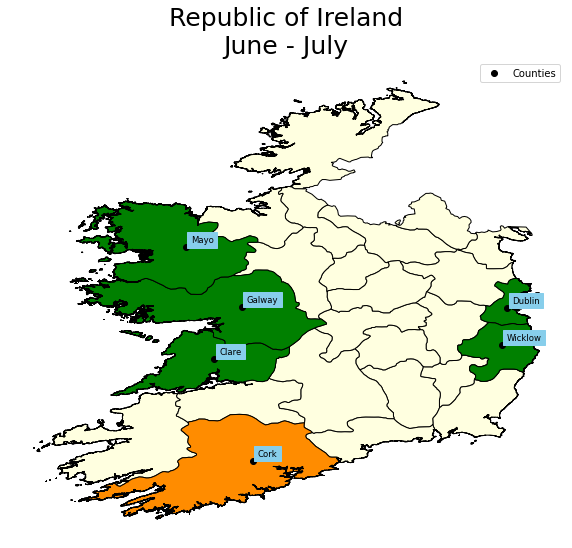

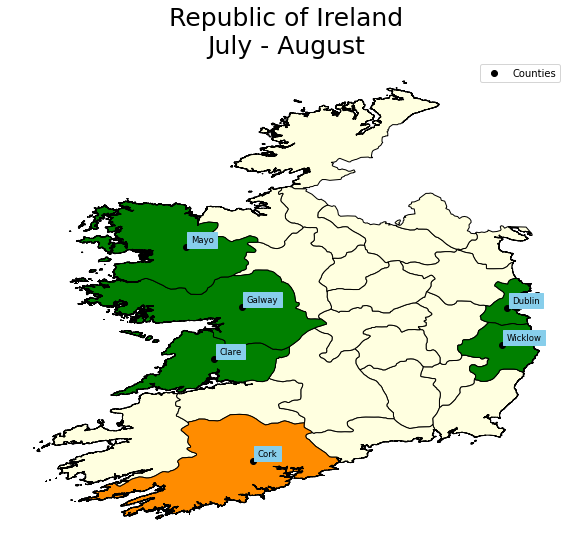

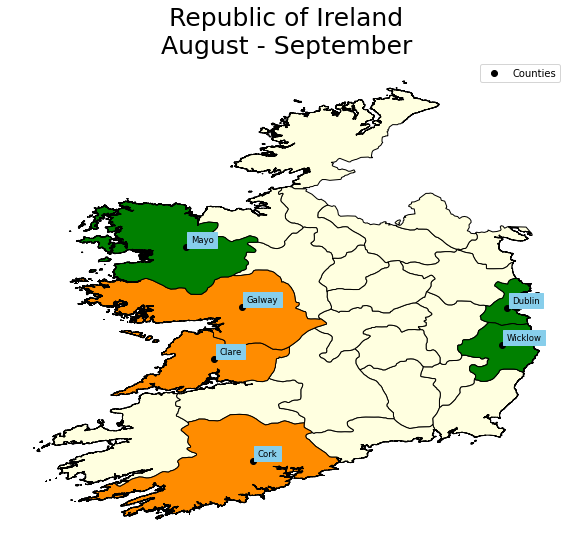

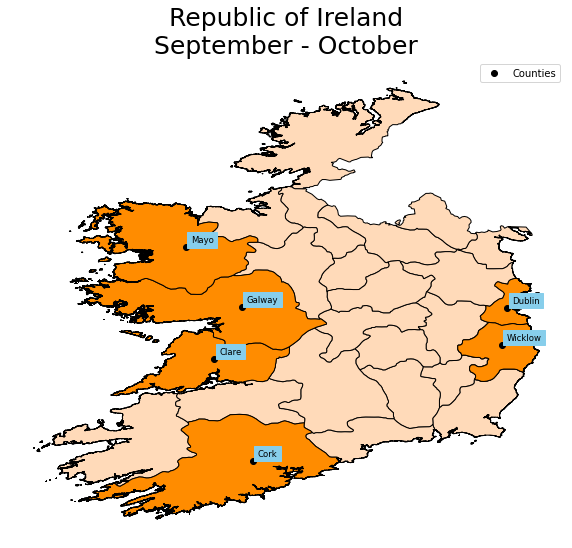

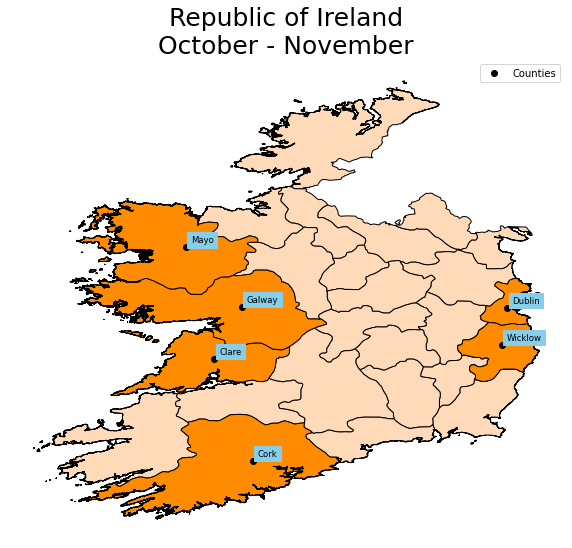

In [14]:
###########################################################
#                     MAP (Start)                         #  
###########################################################

# Since there are 8 months, we should have 8 maps each with 5 counties on it colored in their own zone and the country too

month_range = ['March - April', 'April - May', 'May - June', 'June - July', 'July - August', 
               'August - September','September - October','October - November']

# Loop over months loop should be 8 times
for i in range(total_months+1):
    
    # Set figure parameters
    fig, ax = plt.subplots(1, 1, figsize=(10,10),sharex=True)
    
    # Plot Ireland Map and apply color profile
    ax = map_df.plot(ax=ax,color=country_profile[i], edgecolor='black')
    
    # Plot Counties only that are in the list and apply color profile to counties
    ax = multiple_counties_map_df.plot(ax=ax,color=np.array(county_profile).T[i], edgecolor='black')
    counties_df[counties_df.County.isin(county_list)].plot(ax=ax,color='black')
    
    #Adding MAP title, County labels to the dot and legend
    for x, y, label in zip(counties_df.geometry.x, counties_df.geometry.y, counties_df.County):
        if label in(county_list):
            ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points",backgroundcolor="skyblue",size=8.5)

    ax.axis('off')
    ax.legend(['Counties'])
    ax.set_title('Republic of Ireland\n'+month_range[i], fontdict={'fontsize': 25, 'fontweight' : 3})
###########################################################
#                     MAP (End)                           #  
###########################################################